In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants
from pynufft import NUFFT
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"
import sys
sys.path.append('./Modules')
import monostatic_reconstruct as mr

mm = 1E-3
C = scipy.constants.c

### Load data & antenna coordinates

In [3]:
d_antennas = .035        # distance between tx/rx antennas
fc = 22E9
bw = 2E9

mat = scipy.io.loadmat(r'..\..\Data\copper_O_2022-11-02.mat')
notes = list(mat['notes'])
print('NOTES:')
for i in range(len(notes)):
        print(notes[i])
f = mat['f'][0,:]
Xa = np.flip(mat['X']*mm, axis=(0,1))   # flipping to recover right-handed coordinate systems
Ya = np.flip(mat['Y']*mm, axis=(0,1))       # flipping because origin of scan stage was at top left
Za = np.zeros_like(Xa)
measurements = np.flip(mat['measurements'], axis=(0,1))
z_offset = mat['z_offset'][0,0]*mm

### load background
mat = scipy.io.loadmat(r'..\..\Data\background_2022-10-29.mat')
bg = np.flip(mat['measurements'], axis=(0,1))

### subtract background from measurements
measurements = measurements - bg

NOTES:
160 mm copper circle.


### Reconstruct

In [6]:
recon = mr.MonostaticReconstruction(f, Xa, Ya, z_offset, measurements)
recon.reconstruct((1, 1, 1), (10*mm, 10*mm, 10*mm), Lxa=0.3, Lya=0.3, fc=22E9, bw=2E9, scene_offsets=(0,0,z_offset))

### Plot

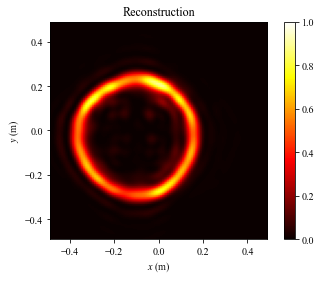

In [7]:
# recon.resample(.5)
# recon.plot(plot_type='xy', scale='linear', cmap='hot')
recon.plot(plot_type='section', slice_axis='z', scale='linear', cmap='hot')
# recon.plot(plot_type='3D', scale='dB')